# Quadratic Unconstrained Integer Optimization

My version of QUIO is inspired by Dwave QUBO solver but tries to minimize an integer equation (as opposed to binary). The equation is as follows:
$$QUIO = \sum_i \alpha_i x_i + \sum_{i<j} \beta_{ij} x_ix_j + \sum_{i} \gamma_i x_i^2$$
The elements of the magnitude vector in the QIO class are the $\alpha_i$s, the offdiagonal elements of the coupling matrix are the $\beta_{ij}$ while the diagonal elements are the $\gamma_i$s.

At this point (version 0) no other parameters (including the annealing parameters) can be controlled and everything is preset.

In [363]:
import numpy as np
from pynq import allocate
from pynq import Overlay, Register
from matplotlib import pyplot as plot
from time import sleep
from copy import deepcopy

In [380]:
class QIO(Overlay):
    """
        req: Overlay, allocate, numpy
    """
    def __init__(self, ol_path, QIO_size=256):
        super().__init__(ol_path)
        self.input_buffer = allocate(shape = (4 + QIO_size + (QIO_size + 1) * QIO_size,), dtype = np.float32)
        self.output_buffer = allocate(shape = (QIO_size,), dtype = np.int32)
        self.init = np.zeros((QIO_size,))
        self.couplings = np.zeros((QIO_size, QIO_size))
        self.magnitude = np.zeros((QIO_size,))
        self.output = np.zeros((QIO_size,))
        self.QIO_size = QIO_size

    def __reset__(self):
        self.init = np.zeros((self.QIO_size,))
        self.couplings = np.zeros((self.QIO_size, self.QIO_size))
        self.magnitude = np.zeros((self.QIO_size,))

    def __start__(self):
        # XORSHIFT128
        self.input_buffer[0] = np.random.randint(np.iinfo(np.int32).max)
        self.input_buffer[1] = np.random.randint(np.iinfo(np.int32).max)
        self.input_buffer[2] = np.random.randint(np.iinfo(np.int32).max)
        self.input_buffer[3] = np.random.randint(np.iinfo(np.int32).max)
        self.input_buffer[4:(self.QIO_size + 4)] = self.init
        self.input_buffer[
            (self.QIO_size ** 2 + self.QIO_size + 4):(self.QIO_size ** 2 + 2*self.QIO_size + 4)
        ] = self.magnitude
        self.input_buffer[
            (self.QIO_size + 4):(self.QIO_size ** 2 + self.QIO_size + 4)
        ] = self.couplings.reshape(
            self.QIO_size ** 2
        )

        self.DMA2QIO.sendchannel.transfer(self.input_buffer)
        self.QIO2DMA.recvchannel.transfer(self.output_buffer)
        self.QIO_accel.register_map.CTRL[0] = 1
        self.DMA2QIO.sendchannel.wait()
        self.QIO2DMA.recvchannel.wait()

        self.output = deepcopy(self.output_buffer)

    def __repr__(self):
        return f'Control register: {self.QIO_accel.register_map.CTRL}'

Loading the bistream:

In [381]:
ol = QIO(f'/home/xilinx/pynq/overlays/RO/QIO.bit')

## Example:
Next we prepare a sample problem where we want the first five variables to add up to 377 and the others to add up to zero. Therefore, we prepare an optimization problem as follows:
$$(\sum_0^4 x_i - 377)^2 + (\sum_5^{255} x_i - 0)^2 = \sum_{i = 0, i < j}^{4} 2x_ix_j + \sum_{i = 5, i < j}^{255} 2x_ix_j - 754\sum_0^4 x_i + \sum_0^{255} x_i^2$$
where we ignored the constant as it has no effect in minimization.

In [373]:
k = 5
for i in range(256):
    ol.couplings[i,i] = 1
    if i < k:
        ol.magnitude[i] = -754
        for j in range(k):
            if i < j:
                ol.couplings[i,j] = 2
    else:
        for j in range(k,256):
            if i < j:
                ol.couplings[i,j] = 2

We can now turn on the solver to solve the shit out of it.

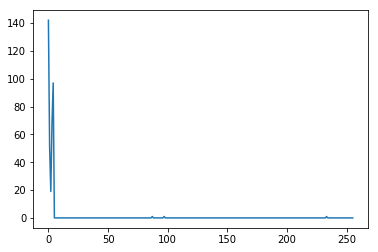

In [374]:
#%%timeit
ol.__start__()
plot.plot(ol.output)

In [375]:
ol.output.sum()

PynqBuffer(380)

Since things are random, another run might mean another solution:

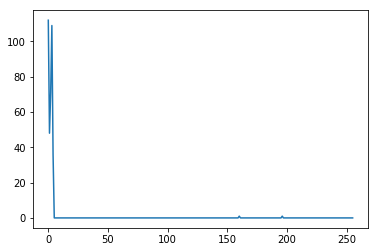

In [376]:
ol.__start__()
plot.plot(ol.output)

In [377]:
ol.output.sum()

PynqBuffer(378)

In [378]:
# We can set the starting point to the previous solution 
# ol.init = deepcopy(ol.output)
# we can also reset to solve another problem
ol.__reset__()

In [379]:
ol.output[:50]

PynqBuffer([112,  48,  71, 109,  36,   0,   0,   0,   0,   0,   0,   0,
              0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
              0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
              0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
              0,   0])